<!-- Projeto Desenvolvido na Data Science Academy - www.datascienceacademy.com.br -->
# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Machine Learning Para Aplicações Biomédicas</font>
## <font color='blue'>Projeto 2</font>
### <font color='blue'>Análise de Dados de Exames Médicos Para Previsão de Doenças com Modelo XGBoost</font>

## Pacotes Python Usados no Projeto

In [1]:
!pip install -q -U watermark

O procedimento de instalação de pacotes e dependências está no arquivo LEIAME.txt

In [2]:
#!pip install -q xgboost

In [3]:
# Import
import pickle
import sklearn as sk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, roc_curve
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
%reload_ext watermark
%watermark -a "Data Science Academy"

Author: Data Science Academy



## Etapa 1 - Definindo e Compreendendo o Problema a Ser Resolvido

Objetivo: Prever se um paciente está tendo uma convulsão ou não através de 178 leituras de EEG (Eletroencefalograma) por segundo.

## Etapa 2 - Compreensão dos Dados

O conjunto de dados inclui 4097 leituras de eletroencefalograma (EEG) por paciente durante 23,5 segundos, com 500 pacientes no total. Os 4097 pontos de dados foram então divididos igualmente em 23 partes por paciente, cada parte é convertida em uma linha no conjunto de dados. Cada linha contém 178 leituras, que são transformadas em colunas; em outras palavras, existem 178 colunas que compõem um segundo das leituras de EEG. No total, existem 11.500 linhas e 179 colunas com a última coluna contendo o status do paciente, esteja ele tendo uma convulsão ou não.

## Etapa 3 - Carregando os Dados

In [5]:
# Carregando os dados
df_dsa = pd.read_csv("dados/dados_originais.csv")

In [6]:
# Shape
df_dsa.shape

(11500, 180)

In [7]:
# Visualizando alguns registros
df_dsa.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,5
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,5
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,5


## Etapa 4 - Análise Exploratória e Definição da Variável Alvo

Vamos criar uma coluna chamada LABEL_VARIAVEL_TARGET em que 1 é quando um paciente está tendo uma convulsão e 0 é quando um paciente não está tendo uma convulsão.

Na última coluna, somente o valor 1 representa convulsão. Os demais valores não representam convulsão.

In [8]:
# Colocando True onde o valor for igual a 1 e False onde o valor for diferente.
df_dsa["LABEL_VARIAVEL_TARGET"] = df_dsa.y == 1

In [9]:
# Visualizando alguns registros
df_dsa.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X171,X172,X173,X174,X175,X176,X177,X178,y,LABEL_VARIAVEL_TARGET
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-15,-31,-77,-103,-127,-116,-83,-51,4,False
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,150,146,152,157,156,154,143,129,1,True
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,64,48,19,-12,-30,-35,-35,-36,5,False
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-81,-80,-77,-85,-77,-72,-69,-65,5,False
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,2,-12,-32,-41,-65,-83,-89,-73,5,False


In [10]:
# Ajusta o tipo para int
df_dsa["LABEL_VARIAVEL_TARGET"] = df_dsa["LABEL_VARIAVEL_TARGET"].astype(int)

In [11]:
# Visualizando alguns registros
df_dsa.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X171,X172,X173,X174,X175,X176,X177,X178,y,LABEL_VARIAVEL_TARGET
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-15,-31,-77,-103,-127,-116,-83,-51,4,0
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,150,146,152,157,156,154,143,129,1,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,64,48,19,-12,-30,-35,-35,-36,5,0
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-81,-80,-77,-85,-77,-72,-69,-65,5,0
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,2,-12,-32,-41,-65,-83,-89,-73,5,0


In [12]:
# A coluna original (y) que continha se um paciente está tendo uma convulsão será eliminada, pois era uma variável 
# categórica com 5 status diferentes. Desde então, convertemos isso em uma variável numérica binária 
# chamada LABEL_VARIAVEL_TARGET.
df_dsa.pop('y')

0        4
1        1
2        5
3        5
4        5
        ..
11495    2
11496    1
11497    5
11498    3
11499    4
Name: y, Length: 11500, dtype: int64

In [13]:
# Visualizando alguns registros
df_dsa.head()

,Unnamed: 0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,LABEL_VARIAVEL_TARGET
0,X21.V1.791,135,190,229,223,192,125,55,-9,-33,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,0
1,X15.V1.924,386,382,356,331,320,315,307,272,244,...,164,150,146,152,157,156,154,143,129,1
2,X8.V1.1,-32,-39,-47,-37,-32,-36,-57,-73,-85,...,57,64,48,19,-12,-30,-35,-35,-36,0
3,X16.V1.60,-105,-101,-96,-92,-89,-95,-102,-100,-87,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,0
4,X20.V1.54,-9,-65,-98,-102,-78,-48,-16,0,-21,...,4,2,-12,-32,-41,-65,-83,-89,-73,0


In [14]:
# A primeira coluna será descartada devido à sua inutilidade em nosso modelo de aprendizado de máquina. 
# Não precisamos do ID
df_dsa.drop(df_dsa.columns[0], axis = 1, inplace = True)

In [15]:
# Visualizando alguns registros
df_dsa.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,LABEL_VARIAVEL_TARGET
0,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,0
1,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,1
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,0
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,0
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,4,2,-12,-32,-41,-65,-83,-89,-73,0


In [16]:
print("Número de colunas:", len(df_dsa.columns))

Número de colunas: 179


In [17]:
# Verificando valores ausentes
df_dsa.isna().sum().sum()

np.int64(0)

As colunas foram divididas para capturar a leitura do EEG em um ponto no tempo e todos os pontos no tempo (todas as 178 colunas) existem no mesmo segundo. Cada linha tem as 178 colunas com as medidas, mais a coluna indicando se as medidas são de convulsão ou não.

## Etapa 5 - Calculando a Prevalência da Classe Positiva

A prevalência é a porcentagem de amostras que tem a característica que você está tentando prever. Nesse cenário específico, significa que as pessoas que têm uma convulsão representam a classe positiva (ocorrência do evento), enquanto as que não sofrem convulsão representam a classe negativa (não ocorrência do evento). 

A taxa é calculada por (número de amostras positivas / número de amostras). Portanto, uma taxa de prevalência de 0,2 significa que 20% de nossa amostra são de pacientes que tiveram convulsão.

In [18]:
# Esta função calcula a prevalência da classe positiva (label = 1)
def calcula_prevalencia(y_actual):
    return sum(y_actual) / len(y_actual)

In [19]:
print("Prevalência da classe positiva: %.3f"% calcula_prevalencia(df_dsa["LABEL_VARIAVEL_TARGET"].values))

Prevalência da classe positiva: 0.200


## Etapa 6 - Limpeza dos Dados

Para o conjunto de dados da epilepsia, existem 178 recursos (colunas), no entanto, uma vez que cada coluna representa um ponto de dados em um ponto específico no tempo e são todas as leituras de EEG, não há necessidade de realizar transformação adicional.

In [20]:
# Preparando o dataset somente com os dados de interesse
collist = df_dsa.columns.tolist()
cols_input = collist[0:178]
df_data = df_dsa[cols_input + ["LABEL_VARIAVEL_TARGET"]]

In [21]:
df_data.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,LABEL_VARIAVEL_TARGET
0,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,0
1,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,1
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,0
3,-105,-101,-96,-92,-89,-95,-102,-100,-87,-79,...,-82,-81,-80,-77,-85,-77,-72,-69,-65,0
4,-9,-65,-98,-102,-78,-48,-16,0,-21,-59,...,4,2,-12,-32,-41,-65,-83,-89,-73,0


In [22]:
# Checando se temos colunas duplicadas nos dados de entrada
dup_cols = set([x for x in cols_input if cols_input.count(x) > 1])
print(dup_cols)
assert len(dup_cols) == 0, "você duplicou colunas em cols_input"

set()


In [23]:
# Checando se temos colunas duplicadas no dataset final
cols_df_data = list(df_data.columns)
dup_cols = set([x for x in cols_df_data if cols_df_data.count(x) > 1])
print(dup_cols)
assert len(dup_cols) == 0,'você duplicou colunas em df_data'

set()


## Etapa 7 - Divisão dos Dados em Treino, Validação e Teste

Geralmente, podemos dividir o conjunto de dados em 50/25/25, 60/20/20, 70/15/15 como a divisão para amostras de treinamento / validação / teste; isso também depende de quantas amostras temos. Se tivermos um conjunto de dados extremamente grande (centenas de milhões de linhas), podemos usar uma divisão como 98/1/1. 

A divisão de treinamento é usada para treinar nosso algoritmo de aprendizado de máquina, por isso queremos usar a maioria de nosso conjunto de dados. O conjunto de dados de validação é usado para ajustar os hiperparâmetros e selecionar a abordagem de melhor desempenho. O conjunto de dados de teste é usado para testar a precisão do nosso modelo de aprendizado de máquina.

Leia o material no Capítulo 6 sobre Data Leakage.

In [24]:
# Gerando amostras aleatórias dos dados
df_data = df_data.sample(n = len(df_data))

In [25]:
# Ajustando os índices do dataset
df_data = df_data.reset_index(drop = True)

In [26]:
# Gera um índice para a divisão
df_valid_teste = df_data.sample(frac = 0.3)
print("Tamanho da divisão de validação / teste: %.1f" % (len(df_valid_teste) / len(df_data)))

Tamanho da divisão de validação / teste: 0.3


In [27]:
# Fazendo a divisão

# Dados de teste
df_teste = df_valid_teste.sample(frac = 0.5)

# Dados se validação
df_valid = df_valid_teste.drop(df_teste.index)

# Dados de treino
df_treino = df_data.drop(df_valid_teste.index)

In [28]:
# Verifique a prevalência de cada subconjunto
print("Teste(n = %d): %.3f" % (len(df_teste), calcula_prevalencia(df_teste.LABEL_VARIAVEL_TARGET.values)))
print("Validação(n = %d): %.3f" % (len(df_valid), calcula_prevalencia(df_valid.LABEL_VARIAVEL_TARGET.values)))
print("Treino(n = %d): %.3f" % (len(df_treino), calcula_prevalencia(df_treino.LABEL_VARIAVEL_TARGET.values)))

Teste(n = 1725): 0.204
Validação(n = 1725): 0.199
Treino(n = 8050): 0.199


In [29]:
print('Todas as amostras (n = %d)'%len(df_data))
assert len(df_data) == (len(df_teste) + len(df_valid) + len(df_treino)), 'algo saiu errado'

Todas as amostras (n = 11500)


Queremos equilibrar nosso conjunto de dados para evitar a criação de um modelo em que ele classifique incorretamente as amostras como pertencentes à classe majoritária. Por exemplo, se tivermos um conjunto de dados de detecção de fraude e a maioria dos casos for "Não é fraude", o modelo de classificação binária tenderia a favorecer a classe "Não é fraude", o que leva a resultados enganosos.

Equilibramos nosso conjunto de dados para que as proporções de cada classe sejam as mesmas para evitar a criação de um modelo "burro".

Como temos 2300 amostras positivas, podemos usar o método de balanceamento de subamostras para usar apenas um subconjunto aleatório das amostras negativas.

## Etapa 8 - Balanceamento de Classe

Leia o material no Capítulo 6 sobre os impactos do Balanceamento de Classe.

In [30]:
# Cria um índice
rows_pos = df_treino.LABEL_VARIAVEL_TARGET == 1

In [31]:
# Define valores positivos e negativos do índice
df_train_pos = df_treino.loc[rows_pos]
df_train_neg = df_treino.loc[~rows_pos]

In [32]:
# Valor mínimo
n = np.min([len(df_train_pos), len(df_train_neg)])

In [33]:
# Obtém valores aleatórios para o dataset de treino
df_treino_final = pd.concat([df_train_pos.sample(n = n, random_state = 64), 
                             df_train_neg.sample(n = n, random_state = 64)], 
                            axis = 0, 
                            ignore_index = True)

In [34]:
# Amostragem
df_treino_final = df_treino_final.sample(n = len(df_treino_final), random_state = 64).reset_index(drop = True)

In [35]:
print('Balanceamento em Treino(n = %d): %.3f'%(len(df_treino_final), 
                                               calcula_prevalencia(df_treino_final.LABEL_VARIAVEL_TARGET.values)))

Balanceamento em Treino(n = 3210): 0.500


In [36]:
# Salvamos todos os datasets em disco no formato csv.
df_treino.to_csv('dados/dados_treino.csv', index = False)
df_treino_final.to_csv('dados/dados_treino_final.csv', index = False)
df_valid.to_csv('dados/dados_valid.csv', index = False)
df_teste.to_csv('dados/dados_teste.csv', index = False)

In [37]:
# Salvamos os dados de entrada (colunas preditoras) para facilitar a utilização mais tarde
pickle.dump(cols_input, open('dados/cols_input.sav', 'wb'))

> Criamos as Matrizes X e Y.

In [38]:
# X
X_treino = df_treino_final[cols_input].values
X_valid = df_valid[cols_input].values

In [39]:
# Y
y_treino = df_treino_final['LABEL_VARIAVEL_TARGET'].values
y_valid = df_valid['LABEL_VARIAVEL_TARGET'].values

In [40]:
# Print
print('Shape dos dados de treino:', X_treino.shape, y_treino.shape)
print('Shape dos dados de validação:', X_valid.shape, y_valid.shape)

Shape dos dados de treino: (3210, 178) (3210,)
Shape dos dados de validação: (1725, 178) (1725,)


In [41]:
X_treino

array([[ 218,  389,  481, ...,  320,  296,  254],
       [ 384,  360,  334, ...,  334,  386,  405],
       [  16,   52,   64, ...,   75,   93,   72],
       ...,
       [  38,   35,   29, ...,   33,   32,   37],
       [-319, -307, -244, ..., -172, -175, -178],
       [  76,   57,    7, ...,  -37,  -40,  -73]], shape=(3210, 178))

## Etapa 9 - Padronização

Leia o material no Capítulo 6 sobre os quando aplicar Padronização.

In [42]:
# Cria o objeto
scaler = StandardScaler()

In [43]:
# Faz o fit
scaler.fit(X_treino)

,copy,True
,with_mean,True
,with_std,True


In [44]:
# Salva o objeto em disco e carrega para usamos adiante
scalerfile = 'dados/scaler.sav'

In [45]:
pickle.dump(scaler, open(scalerfile, 'wb'))
scaler = pickle.load(open(scalerfile, 'rb'))

In [46]:
# Aplica a normalização em nossas matrizes de dados
X_treino_tf = scaler.transform(X_treino)
X_valid_tf = scaler.transform(X_valid)

In [47]:
X_treino_tf

array([[ 0.96483252,  1.64174521,  2.03555186, ...,  1.40633638,
         1.28917604,  1.09482089],
       [ 1.64380318,  1.52418444,  1.43056577, ...,  1.46434794,
         1.65638553,  1.69822255],
       [ 0.13861521,  0.27560796,  0.31936681, ...,  0.391134  ,
         0.46091464,  0.36754208],
       ...,
       [ 0.22859928,  0.20669303,  0.1753225 , ...,  0.21709931,
         0.21202821,  0.22768077],
       [-1.23159666, -1.17971332, -0.94822311, ..., -0.63235574,
        -0.63255362, -0.63146728],
       [ 0.3840263 ,  0.29587706,  0.08478036, ..., -0.07295851,
        -0.08173938, -0.21188335]], shape=(3210, 178))

## Etapa 10 - Modelagem Preditiva

Vamos criar funções auxiliares para o cálculo das métricas.

In [48]:
# Função para calcular a especificidade
def dsa_calc_specificity(y_actual, y_pred, thresh):
    return sum((y_pred < thresh) & (y_actual == 0)) / sum(y_actual ==0)

In [49]:
# Função para gerar relatório de métricas
def dsa_print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    
    recall = recall_score(y_actual, (y_pred > thresh))
    
    precision = precision_score(y_actual, (y_pred > thresh))
    
    specificity = dsa_calc_specificity(y_actual, y_pred, thresh)
    
    print('AUC:%.3f'%auc)
    print('Acurácia:%.3f'%accuracy)
    print('Recall:%.3f'%recall)
    print('Precisão:%.3f'%precision)
    print('Especificidade:%.3f'%specificity)
    print(' ')
    
    return auc, accuracy, recall, precision, specificity 

Como equilibramos nossos dados de treinamento, vamos definir nosso limite em 0,5 para rotular uma amostra prevista como positiva.

In [50]:
thresh = 0.5

### Versão 1 do Modelo com Regressão Logística

Veja a definição do algoritmo no videobook do Capítulo 7.

In [51]:
# Construção do modelo

# Cria o classificador (objeto)
lr = LogisticRegression(max_iter = 500, random_state = 142)

# Treina e cria o modelo
modelo_dsa_v1 = lr.fit(X_treino_tf, y_treino)

# Previsões 
y_train_preds = modelo_dsa_v1.predict_proba(X_treino_tf)[:,1]
y_valid_preds = modelo_dsa_v1.predict_proba(X_valid_tf)[:,1]

print('\nRegressão Logística\n')

print('Treinamento:\n')
v1_train_auc, v1_train_acc, v1_train_rec, v1_train_prec, v1_train_spec = dsa_print_report(y_treino, 
                                                                                          y_train_preds, 
                                                                                          thresh)

print('Validação:\n')
v1_valid_auc, v1_valid_acc, v1_valid_rec, v1_valid_prec, v1_valid_spec = dsa_print_report(y_valid, 
                                                                                          y_valid_preds, 
                                                                                          thresh)


Regressão Logística

Treinamento:

AUC:0.628
Acurácia:0.664
Recall:0.531
Precisão:0.723
Especificidade:0.796
 
Validação:

AUC:0.535
Acurácia:0.707
Recall:0.437
Precisão:0.324
Especificidade:0.774
 


### Versão 2 do Modelo com Naive Bayes

Veja a definição do algoritmo no videobook do Capítulo 7.

In [52]:
# Construção do modelo

# Cria o classificador (objeto)
nb = GaussianNB()

# Treina e cria o modelo
modelo_dsa_v2 = nb.fit(X_treino_tf, y_treino)

# Previsões
y_train_preds = modelo_dsa_v2.predict_proba(X_treino_tf)[:,1]
y_valid_preds = modelo_dsa_v2.predict_proba(X_valid_tf)[:,1]

print('\nNaive Bayes\n')

print('Treinamento:\n')
v2_train_auc, v2_train_acc, v2_train_rec, v2_train_prec, v2_train_spec = dsa_print_report(y_treino, 
                                                                                          y_train_preds, 
                                                                                          thresh)

print('Validação:\n')
v2_valid_auc, v2_valid_acc, v2_valid_rec, v2_valid_prec, v2_valid_spec = dsa_print_report(y_valid, 
                                                                                          y_valid_preds, 
                                                                                          thresh)


Naive Bayes

Treinamento:

AUC:0.983
Acurácia:0.934
Recall:0.900
Precisão:0.966
Especificidade:0.968
 
Validação:

AUC:0.982
Acurácia:0.958
Recall:0.918
Precisão:0.877
Especificidade:0.968
 


### Versão 3 do Modelo com XGBoost (Xtreme Gradient Boosting Classifier)

Veja a definição do algoritmo no videobook do Capítulo 7.


Verifique o Kaggle.

In [53]:
# Construção do modelo

# Cria o classificador
xgbc = XGBClassifier()

# Treina e cria o modelo
modelo_dsa_v3 = xgbc.fit(X_treino_tf, y_treino)

# Previsões
y_train_preds = modelo_dsa_v3.predict_proba(X_treino_tf)[:,1]
y_valid_preds = modelo_dsa_v3.predict_proba(X_valid_tf)[:,1]

print('\nXtreme Gradient Boosting Classifier\n')

print('Treinamento:\n')
v3_train_auc, v3_train_acc, v3_train_rec, v3_train_prec, v3_train_spec = dsa_print_report(y_treino, 
                                                                                          y_train_preds, 
                                                                                          thresh)

print('Validação:\n')
v3_valid_auc, v3_valid_acc, v3_valid_rec, v3_valid_prec, v3_valid_spec = dsa_print_report(y_valid, 
                                                                                          y_valid_preds, 
                                                                                          thresh)


Xtreme Gradient Boosting Classifier

Treinamento:

AUC:1.000
Acurácia:1.000
Recall:1.000
Precisão:1.000
Especificidade:1.000
 
Validação:

AUC:0.992
Acurácia:0.960
Recall:0.959
Precisão:0.857
Especificidade:0.960
 


## Etapa 11 -  Validação Cruzada

Para realizar a validação cruzada no modelo de Xtreme Gradient Boosting Classifier (XGBClassifier), você pode usar a função cross_val_score da biblioteca scikit-learn. Esta função permite avaliar a eficácia do modelo usando diferentes divisões de treino/teste, o que ajuda a obter uma estimativa mais robusta do desempenho do modelo.

In [54]:
# Cria o classificador
xgbc = XGBClassifier()

# Configura a validação cruzada
# Por exemplo, usando 5 divisões e a métrica de área sob a curva ROC (AUC)
n_splits = 5
score = 'roc_auc'

# Realiza a validação cruzada
cv_scores = cross_val_score(xgbc, X_treino_tf, y_treino, cv = n_splits, scoring = score)

# Exibe os resultados
print(f"Validação Cruzada com {n_splits} divisões")
print(f"Score AUC em Cada Divisão: {cv_scores}")
print(f"Média de Score AUC: {np.mean(cv_scores)}")

Validação Cruzada com 5 divisões
Score AUC em Cada Divisão: [0.99378888 0.99122679 0.99379859 0.99281839 0.99370154]
Média de Score AUC: 0.9930668374724624


## Etapa 12 - Otimização de Hiperparâmetros com GridSearchCV

Para realizar a otimização de hiperparâmetros no seu modelo XGBoost, você pode usar o GridSearchCV ou RandomizedSearchCV da biblioteca scikit-learn. Essas ferramentas permitem testar automaticamente várias combinações de hiperparâmetros e selecionar a melhor combinação com base no desempenho do modelo.

Vamos exemplificar como usar o GridSearchCV para otimizar alguns hiperparâmetros do XGBoost. O processo com RandomizedSearchCV seria similar, mas com a diferença de que ele testa um número fixo de combinações de hiperparâmetros escolhidas aleatoriamente, o que pode ser mais eficiente se o espaço de hiperparâmetros for muito grande.

In [55]:
%%time

# Define o classificador
xgbc = XGBClassifier()

# Define o espaço de hiperparâmetros para a otimização
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 0.9]
}

# Configura o GridSearchCV
grid_search = GridSearchCV(xgbc, param_grid, cv = 5, scoring = 'roc_auc', n_jobs = -1)

# Realiza a busca pelos melhores hiperparâmetros
grid_search.fit(X_treino_tf, y_treino)

# Melhores hiperparâmetros encontrados
best_params = grid_search.best_params_

# Treina o modelo com os melhores hiperparâmetros
modelo_dsa_v4 = grid_search.best_estimator_

# Previsões com o modelo otimizado
y_train_preds_optimized = modelo_dsa_v4.predict_proba(X_treino_tf)[:,1]
y_valid_preds_optimized = modelo_dsa_v4.predict_proba(X_valid_tf)[:,1]

# Avaliação do modelo otimizado
print('\nXtreme Gradient Boosting Classifier - Otimizado\n')
print('Melhores hiperparâmetros:', best_params)

print('\nTreinamento:\n')
v4_train_auc, v4_train_acc, v4_train_rec, v4_train_prec, v4_train_spec = dsa_print_report(y_treino, 
                                                                                          y_train_preds_optimized, 
                                                                                          thresh)

print('Validação:\n')
v4_valid_auc, v4_valid_acc, v4_valid_rec, v4_valid_prec, v4_valid_spec = dsa_print_report(y_valid, 
                                                                                          y_valid_preds_optimized, 
                                                                                          thresh)


Xtreme Gradient Boosting Classifier - Otimizado

Melhores hiperparâmetros: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.7}

Treinamento:

AUC:1.000
Acurácia:1.000
Recall:1.000
Precisão:1.000
Especificidade:1.000
 
Validação:

AUC:0.993
Acurácia:0.964
Recall:0.959
Precisão:0.873
Especificidade:0.965
 
CPU times: user 1.73 s, sys: 1.58 s, total: 3.31 s
Wall time: 22.6 s


## Etapa 13 - Seleção do Melhor Modelo de Machine Learning

Vamos criar um dataframe com esses resultados e plotar os resultados usando o seaborn.

In [56]:
# Cria um dataframe com as métricas calculadas
df_results = pd.DataFrame({'classificador':['RL','RL','NB','NB','XGB','XGB','XGB_O','XGB_O'],
                           'data_set':['treino','validação'] * 4,
                           'auc':[v1_train_auc,
                                  v1_valid_auc,
                                  v2_train_auc,
                                  v2_valid_auc,
                                  v3_train_auc,
                                  v3_valid_auc,
                                  v4_train_auc,
                                  v4_valid_auc],
                           'accuracy':[v1_train_acc,
                                       v1_valid_acc,
                                       v2_train_acc,
                                       v2_valid_acc,
                                       v3_train_acc,
                                       v3_valid_acc,
                                       v4_train_acc,
                                       v4_valid_acc],
                           'recall':[v1_train_rec,
                                     v1_valid_rec,
                                     v2_train_rec,
                                     v2_valid_rec,
                                     v3_train_rec,
                                     v3_valid_rec,
                                     v4_train_rec,
                                     v4_valid_rec],
                           'precision':[v1_train_prec,
                                        v1_valid_prec,
                                        v2_train_prec,
                                        v2_valid_prec,
                                        v3_train_prec,
                                        v3_valid_prec,
                                        v4_train_prec,
                                        v4_valid_prec],
                           'specificity':[v1_train_spec,
                                          v1_valid_spec,
                                          v2_train_spec,
                                          v2_valid_spec,
                                          v3_train_spec,
                                          v3_valid_spec,
                                          v4_train_spec,
                                          v4_valid_spec]})

A métrica de desempenho escolhida será a pontuação AUC (AUC Score) do conjunto de validação. É a pontuação ideal para comparar modelos de algoritmos diferentes.

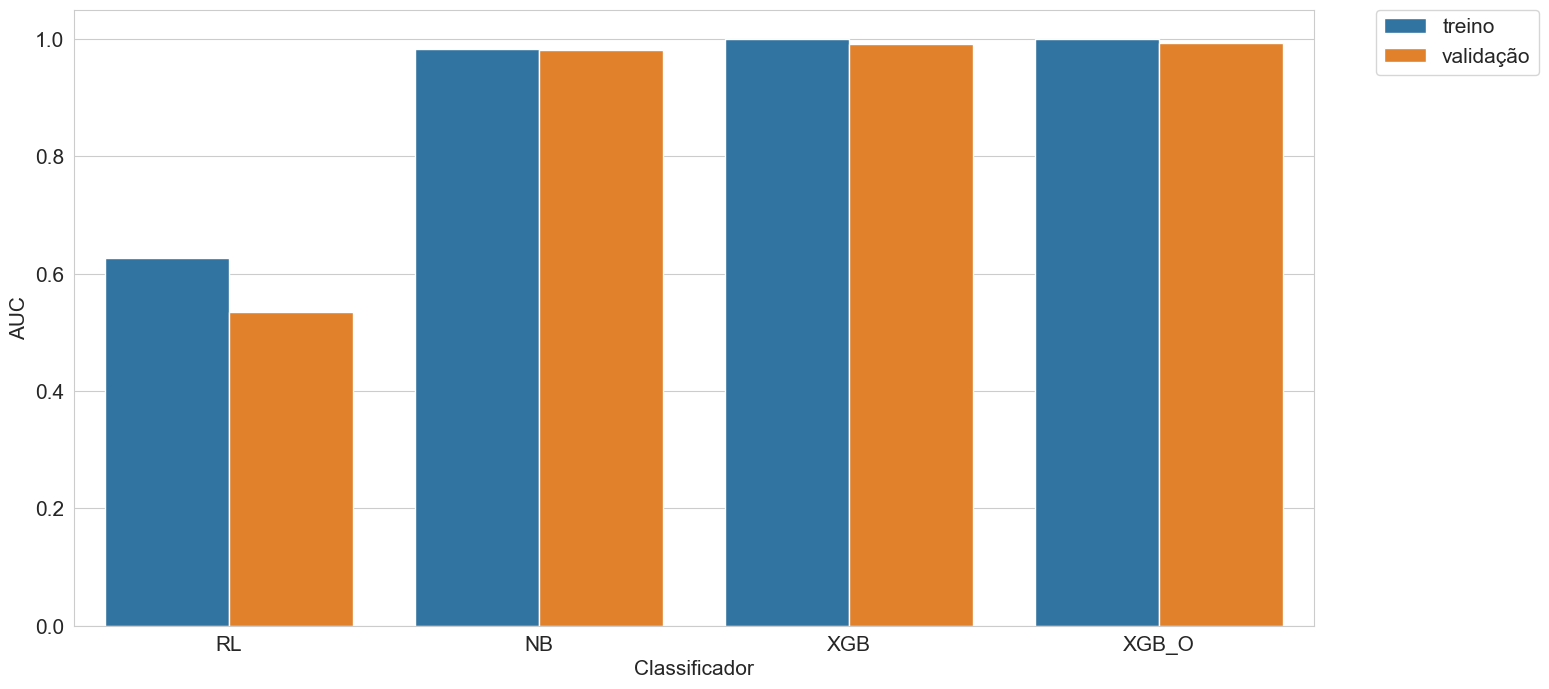

In [57]:
# Construção do Plot
sns.set_style("whitegrid")
plt.figure(figsize=(16, 8))

# Gráfico de barras
ax = sns.barplot(x = 'classificador', y = 'auc', hue = 'data_set', data = df_results)
ax.set_xlabel('Classificador', fontsize = 15)
ax.set_ylabel('AUC', fontsize = 15)
ax.tick_params(labelsize = 15)

# Legenda
plt.legend(bbox_to_anchor = (1.05, 1), loc = 2, borderaxespad = 0., fontsize = 15)
plt.show();

In [58]:
# Tabela de comparação dos modelos
df_results

,classificador,data_set,auc,accuracy,recall,precision,specificity
0,RL,treino,0.627615,0.663863,0.531464,0.722881,0.796262
1,RL,validação,0.534751,0.706667,0.437318,0.323974,0.773517
2,NB,treino,0.982989,0.934268,0.900312,0.965909,0.968224
3,NB,validação,0.981693,0.958261,0.918367,0.877437,0.968162
4,XGB,treino,1.000000,1.000000,1.000000,1.000000,1.000000
5,XGB,validação,0.991948,0.960000,0.959184,0.856771,0.960203
6,XGB_O,treino,1.000000,1.000000,1.000000,1.000000,1.000000
7,XGB_O,validação,0.992994,0.964058,0.959184,0.872679,0.965268


Usaremos como critério de escolha a métrica AUC em validação.

In [59]:
# Tabela de comparação dos modelos somente com métricas em validação e ordenado por AUC
df_results[df_results['data_set'] == 'validação'].sort_values(by='auc', ascending=False)

,classificador,data_set,auc,accuracy,recall,precision,specificity
7,XGB_O,validação,0.992994,0.964058,0.959184,0.872679,0.965268
5,XGB,validação,0.991948,0.960000,0.959184,0.856771,0.960203
3,NB,validação,0.981693,0.958261,0.918367,0.877437,0.968162
1,RL,validação,0.534751,0.706667,0.437318,0.323974,0.773517


Considerando a métrica AUC, nosso melhor modelo é o Classificador XGBoost Versão Otimizada (versão 4). Essa será nossa escolha.

**Nota: Quanto executar na sua máquina os valores podem ser diferentes devido à precisão de cálculo de ponto flutuante da CPU do seu computador. Ajuste a decisão de acordo.**

### Gravando o Melhor Modelo

In [60]:
# Grava o modelo em disco
pickle.dump(modelo_dsa_v4, open('modelos/melhor_modelo_dsa.pkl', 'wb'), protocol = 4)

## Etapa 14 - Avaliação e Interpretação das Métricas

In [61]:
# Carrega o modelo, as colunas e o scaler
melhor_modelo = pickle.load(open('modelos/melhor_modelo_dsa.pkl','rb'))
cols_input = pickle.load(open('dados/cols_input.sav','rb'))
scaler = pickle.load(open('dados/scaler.sav', 'rb'))

# Carrega os dados
df_train = pd.read_csv('dados/dados_treino.csv')
df_valid= pd.read_csv('dados/dados_valid.csv')
df_test= pd.read_csv('dados/dados_teste.csv')

# Cria matrizes x e y

# X
X_train = df_train[cols_input].values
X_valid = df_valid[cols_input].values
X_test = df_test[cols_input].values

# Y
y_train = df_train['LABEL_VARIAVEL_TARGET'].values
y_valid = df_valid['LABEL_VARIAVEL_TARGET'].values
y_test = df_test['LABEL_VARIAVEL_TARGET'].values

# Aplica a transformação nos dados
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)
X_test_tf = scaler.transform(X_test)

> Calculando probabilidades de previsão.

In [62]:
y_train_preds = melhor_modelo.predict_proba(X_train_tf)[:,1]
y_valid_preds = melhor_modelo.predict_proba(X_valid_tf)[:,1]
y_test_preds = melhor_modelo.predict_proba(X_test_tf)[:,1]

> Avaliação de desempenho.

In [63]:
thresh = 0.5

print('\nTreinamento:\n')
train_auc, train_accuracy, train_recall, train_precision, train_specificity = dsa_print_report(y_train,
                                                                                               y_train_preds, 
                                                                                               thresh)

print('\nValidação:\n')
valid_auc, valid_accuracy, valid_recall, valid_precision, valid_specificity = dsa_print_report(y_valid,
                                                                                               y_valid_preds, 
                                                                                               thresh)

print('\nTeste:\n')
test_auc, test_accuracy, test_recall, test_precision, test_specificity = dsa_print_report(y_test,
                                                                                          y_test_preds, 
                                                                                          thresh)


Treinamento:

AUC:0.998
Acurácia:0.979
Recall:1.000
Precisão:0.904
Especificidade:0.973
 

Validação:

AUC:0.993
Acurácia:0.964
Recall:0.959
Precisão:0.873
Especificidade:0.965
 

Teste:

AUC:0.996
Acurácia:0.973
Recall:0.969
Precisão:0.905
Especificidade:0.974
 


> Curva ROC.

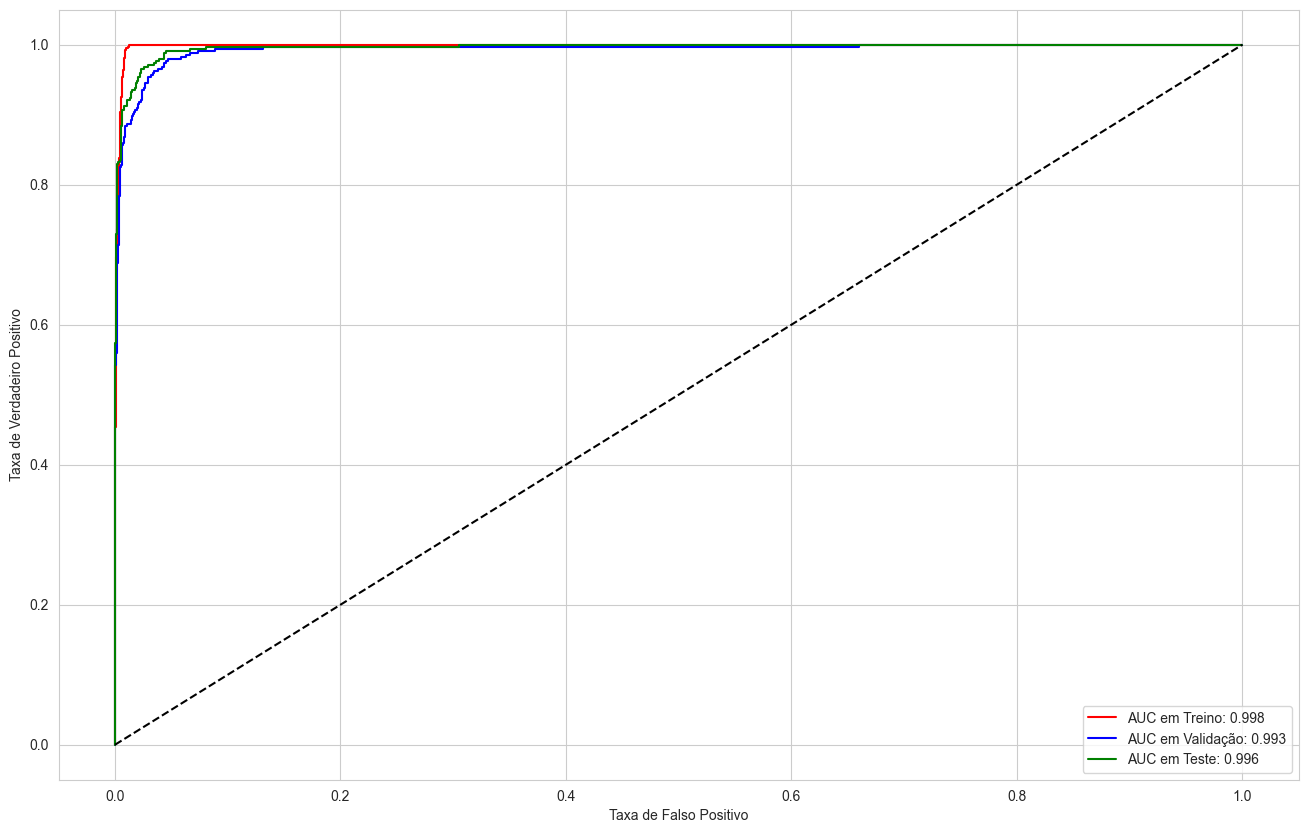

In [64]:
# Calcula a curva ROC nos dados de treino
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_preds)
auc_train = roc_auc_score(y_train, y_train_preds)

# Calcula a curva ROC nos dados de validação
fpr_valid, tpr_valid, thresholds_valid = roc_curve(y_valid, y_valid_preds)
auc_valid = roc_auc_score(y_valid, y_valid_preds)

# Calcula a curva ROC nos dados de teste
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_preds)
auc_test = roc_auc_score(y_test, y_test_preds)

# Plot
plt.figure(figsize=(16,10))
plt.plot(fpr_train, tpr_train, 'r-', label = 'AUC em Treino: %.3f' % auc_train)
plt.plot(fpr_valid, tpr_valid, 'b-', label = 'AUC em Validação: %.3f' % auc_valid)
plt.plot(fpr_test, tpr_test, 'g-', label = 'AUC em Teste: %.3f' % auc_test)
plt.plot([0,1],[0,1],'k--')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.legend()
plt.show()

## Etapa 15 - Deploy do Modelo e Uso com Novos Dados

In [65]:
# Carregando dados de um novo paciente
novo_paciente = pd.read_csv('dados/novo_paciente.csv')

In [66]:
novo_paciente.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X169,X170,X171,X172,X173,X174,X175,X176,X177,X178
0,51,43,34,21,13,12,6,4,1,-4,...,-41,-16,2,22,33,45,56,67,69,63


In [67]:
# Aplicamos a padronização aos novos dados de entrada
novo_paciente_scaled = scaler.transform(novo_paciente)

In [68]:
novo_paciente_scaled

array([[ 0.28177168,  0.23912359,  0.19590026,  0.12946602,  0.07979731,
         0.06053177,  0.02651602,  0.01954744,  0.00610099, -0.01767098,
        -0.05594698, -0.08266041, -0.08941915, -0.07922587, -0.05532675,
        -0.04302038, -0.04362368, -0.05391527, -0.04172833, -0.03958196,
        -0.06515919, -0.05032312, -0.02610952, -0.01070588, -0.01182613,
        -0.00715631,  0.01923675,  0.04522673,  0.07652817,  0.07534033,
         0.05944949,  0.00895251, -0.0062448 , -0.02276352,  0.00342929,
         0.0331846 ,  0.07535078,  0.12123411,  0.14157076,  0.17562796,
         0.18679917,  0.20252721,  0.19072384,  0.20273458,  0.19014509,
         0.17926658,  0.16482052,  0.12442091,  0.07072528,  0.0338274 ,
         0.02707405, -0.02749759, -0.08590271, -0.13616578, -0.17016207,
        -0.19553502, -0.20133482, -0.19784543, -0.18473551, -0.1402614 ,
        -0.09685364, -0.05736488, -0.02427348, -0.04726288, -0.04029014,
        -0.03452318, -0.01759593,  0.03251771,  0.0

In [69]:
# Previsão de probabilidade de cada classe
melhor_modelo.predict_proba(novo_paciente_scaled)

array([[9.996969e-01, 3.030832e-04]], dtype=float32)

In [70]:
# Previsão de classe
melhor_modelo.predict(novo_paciente_scaled)

array([0])

De acordo com os dados do exame, esse paciente não terá uma crise epilética.

In [71]:
%watermark -a "Data Science Academy"

Author: Data Science Academy



In [72]:
#%watermark -v -m

In [73]:
#%watermark --iversions

# Fim